<a href="https://colab.research.google.com/github/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/blob/main/Project_2/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сравнение скоростей работы, потребления памяти, точности аппроксимации в зависимости от ранга CP, Такер, ТТ

Олег Николаев

In [2]:
pip install tntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 524.5 kB/s eta 0:00:00


In [4]:
import torch
torch.set_default_dtype(torch.float64)
import tntorch as tn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [47]:
start = time.time()
print(f'{(time.time() - start):.2f}', 's')

0.00 s


100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


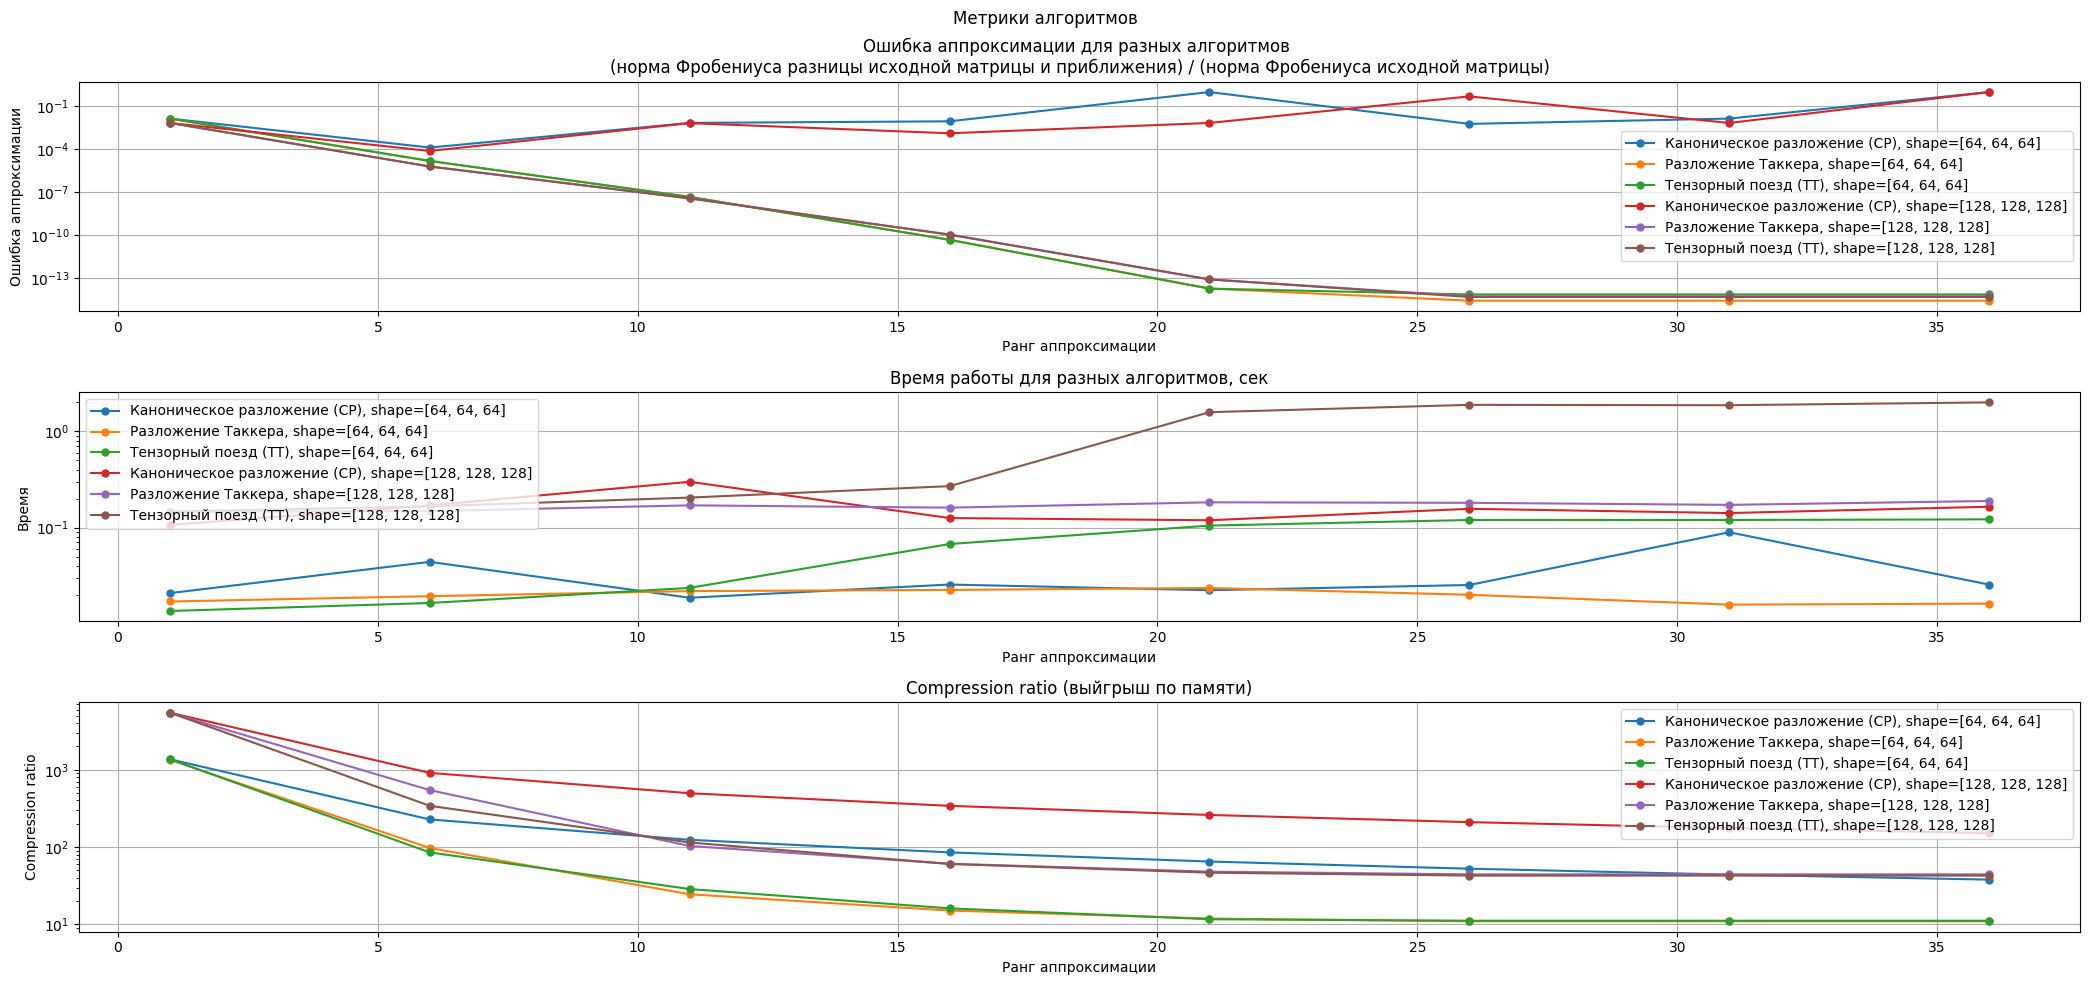

In [81]:
shapes = [64, 128] # исследуем алгоритмы на равносторонних тензорах
R = 40 # максимальный ранг аппроксимации

fig, ax = plt.subplots(3, 1, figsize=(7*3, 10))
for i, shape in enumerate(shapes):
  # инициализируем матрицы
  X, Y, Z = np.meshgrid(range(shape), range(shape), range(shape))
  #full = torch.Tensor(1. / (X + Y + Z + 1))  # аналитическая связь индесов
  full = torch.Tensor(np.sqrt(np.sqrt(X)*(Y+Z) + Y*Z**2)*(X + np.sin(Y)*np.cos(Z)))  # Some analytical 3D function
  # список рангов для малоранговой аппроксимации
  rank_range = np.arange(1, R, 5)

  # БЛОК АЛГОРИТМОВ
  approximation_error = {}
  time_dict = {}
  compression_ratio = {}
  algorithms = ["Каноническое разложение (CP)", "Разложение Таккера", "Тензорный поезд (TT)"]

  for algo in tqdm(algorithms):
    error_array = []
    time_array = []
    compression_array = []
    ranks_cp, ranks_tucker, ranks_tt = None, None, None
    for r in rank_range:
      if algo == "Каноническое разложение (CP)":
        ranks_cp = r
      elif algo == "Разложение Таккера":
        ranks_tucker = r
      elif algo == "Тензорный поезд (TT)":
        ranks_tt = r
      start = time.time()
      t  = tn.Tensor(full, ranks_cp=ranks_cp, ranks_tucker=ranks_tucker, ranks_tt=ranks_tt, verbose=False, tol=1e-5, max_iter=50)
      end = time.time()

      error_array.append(torch.norm(t.torch() - full).item() / torch.norm(full).item())
      time_array.append(end - start)
      compression_array.append(full.numel() / t.numcoef())

    approximation_error[algo] = error_array
    time_dict[algo] = time_array
    compression_ratio[algo] = compression_array
    # print('Compression ratio: {}/{} = {:g}'.format(full.numel(), t.numel(), full.numel() / t.numel()))
    # t.numel: Returns the total number of elements in the input tensor.

  # БЛОК РИСОВАНИЯ
  fig.suptitle("Метрики алгоритмов")

  ax[0].set_title("Ошибка аппроксимации для разных алгоритмов \n(норма Фробениуса разницы исходной матрицы и приближения) / (норма Фробениуса исходной матрицы)")
  for algo, _error in approximation_error.items():
    ax[0].plot(rank_range, _error, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=5, linestyle='-')
  ax[0].set_yscale('log')
  ax[0].set_xlabel("Ранг аппроксимации")
  ax[0].set_ylabel("Ошибка аппроксимации")
  ax[0].legend(loc='best')
  ax[0].grid(True, axis='both')

  ax[1].set_title("Время работы для разных алгоритмов, сек")
  for algo, _time in time_dict.items():
    ax[1].plot(rank_range, _time, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=5, linestyle='-')
  ax[1].set_yscale('log')
  ax[1].set_xlabel("Ранг аппроксимации")
  ax[1].set_ylabel("Время")
  ax[1].legend(loc='best')
  ax[1].grid(True, axis='both')

  ax[2].set_title("Compression ratio (выйгрыш по памяти)")
  for algo, _c_ratio in compression_ratio.items():
    ax[2].plot(rank_range, _c_ratio, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=5, linestyle='-')
  ax[2].set_yscale('log')
  ax[2].set_xlabel("Ранг аппроксимации")
  ax[2].set_ylabel("Compression ratio")
  ax[2].legend(loc='best')
  ax[2].grid(True, axis='both')

fig.tight_layout()
plt.show()
fig.savefig('full_figure.png')


In [13]:
t

3D TT tensor:

 128 128 128
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   20  20  1

Text(0, 0.5, 'Rel approximation error')

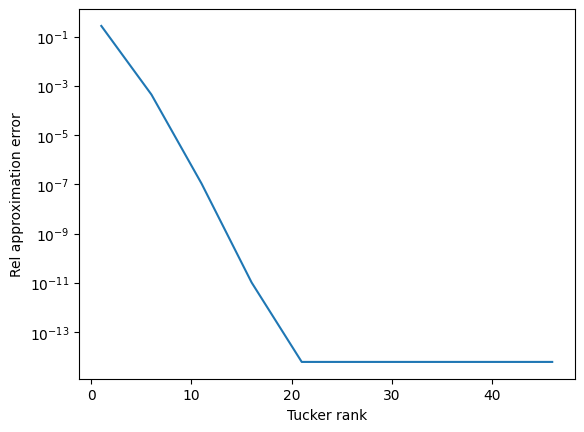

In [6]:
t_error = []
for t_rank in rank_range:
    tt_tucker_t = tn.Tensor(full, ranks_tucker=t_rank)
    t_error.append(torch.norm(tt_tucker_t.torch() - full).item() / torch.norm(full).item())

plt.semilogy(rank_range, t_error)
plt.xlabel("Tucker rank")
plt.ylabel("Rel approximation error")

Text(0, 0.5, 'Rel approximation error')

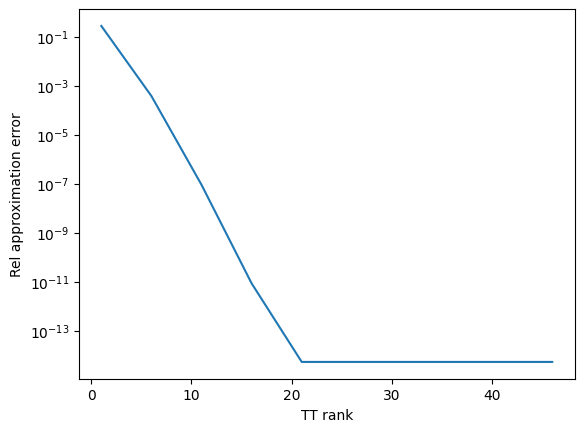

In [7]:
error_rec = []
for r in rank_range:
    tt_t = tn.Tensor(full, ranks_tt=r)
    error_rec.append(torch.norm(tt_t.torch() - full).item() / torch.norm(full).item())
plt.semilogy(rank_range, error_rec)
plt.xlabel("TT rank")
plt.ylabel("Rel approximation error")

In [12]:
print(cp_t)
print(tt_t)
print(tt_tucker_t)
print(cp_t.numcoef(), tt_t.numcoef(), tt_tucker_t.numcoef(), full.numel())

NameError: ignored

# **Тензорный поезд**

Как достижения мультилинейной алгебры помогают преодолеть проклятие размерности?

<div>
<img src="https://raw.githubusercontent.com/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/main/pictures/TT1.png" width="600"/>
</div>

 Источник: iclcollective.com

In [ ]:
https://habr.com/ru/companies/airi/articles/747626/

https://github.com/G-Ryzhakov/Constructive-TT/blob/main/cooperative_games.ipynb